In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The code below is originally created in the lesson at Udacity self-driving car nano degree.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [3]:
# Read in the saved objpoints and imgpoints 
dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

## 1. Distortion-corrected image generation

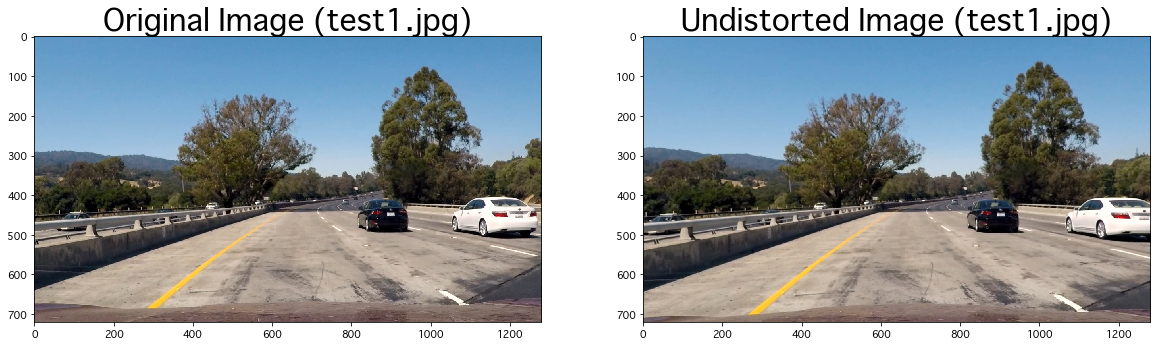

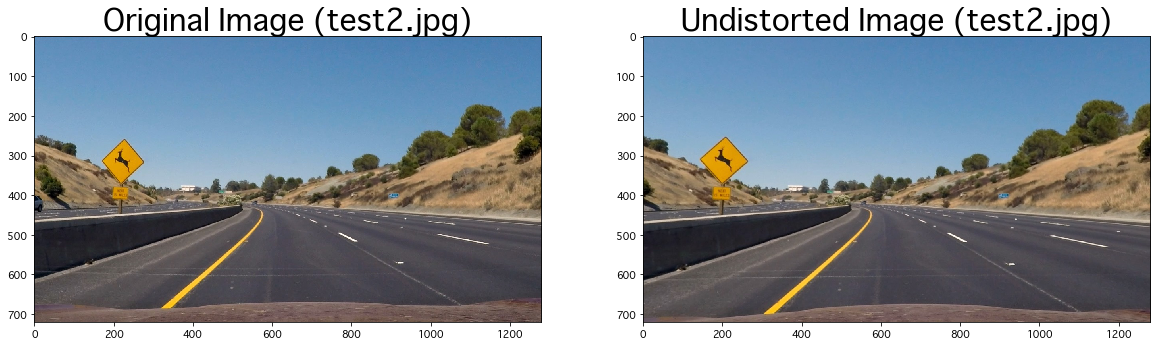

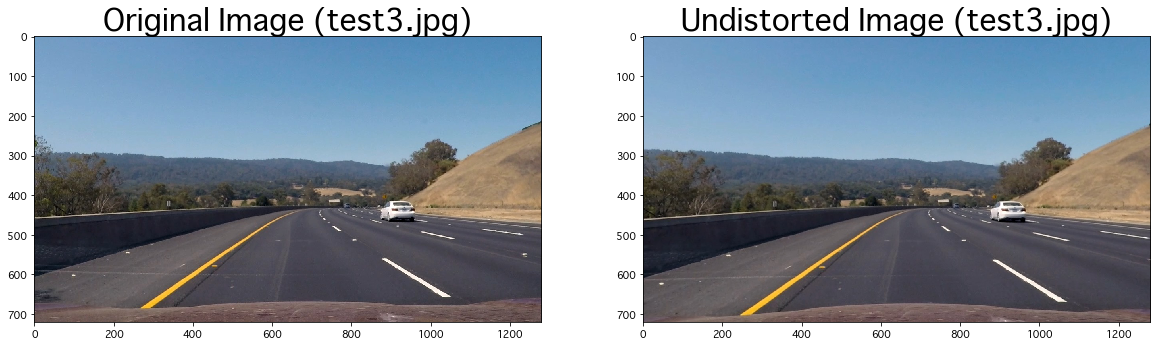

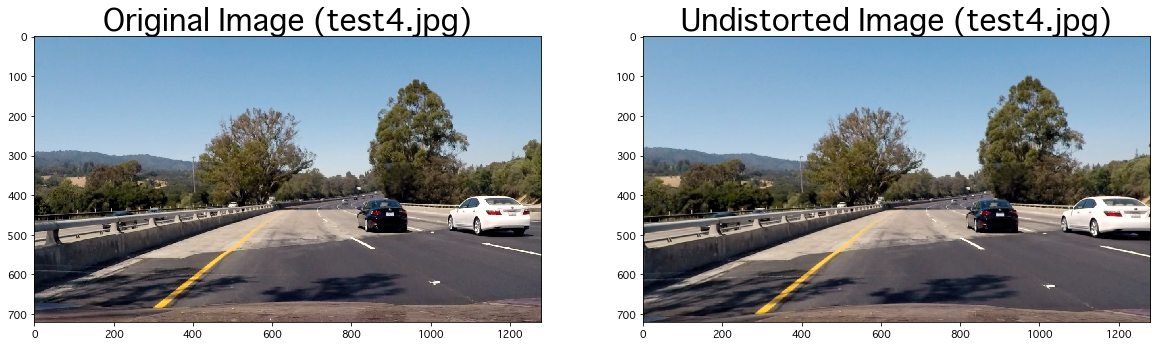

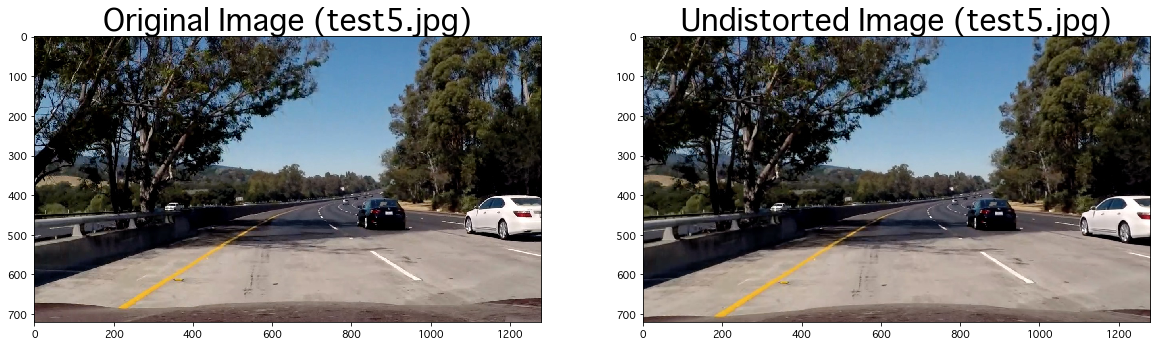

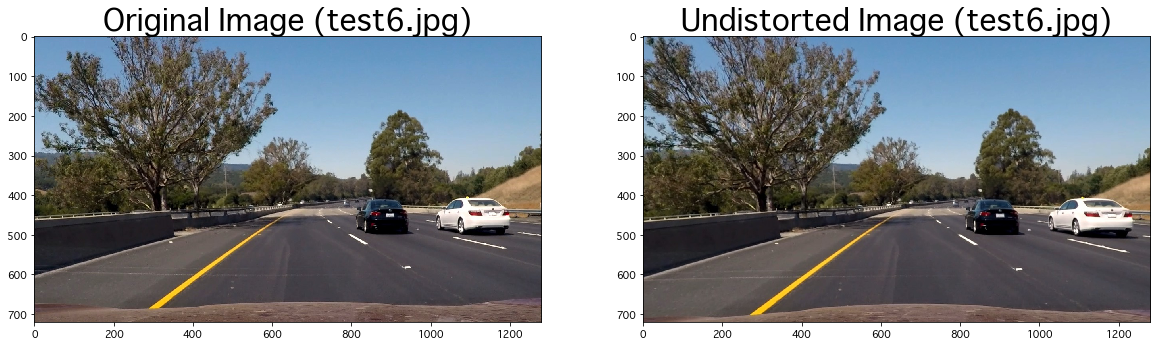

In [5]:
# Step through the list
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # undistort the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image (' + fname.split('/')[-1] + ')', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image (' + fname.split('/')[-1] + ')', fontsize=30)
    plt.savefig(fname.split('/')[0] + '/undistorted_test' + str(idx+1) + '.jpg', bbox_inches='tight')

## 2. Binary image results after gradient and color transformation with the  thresholds.

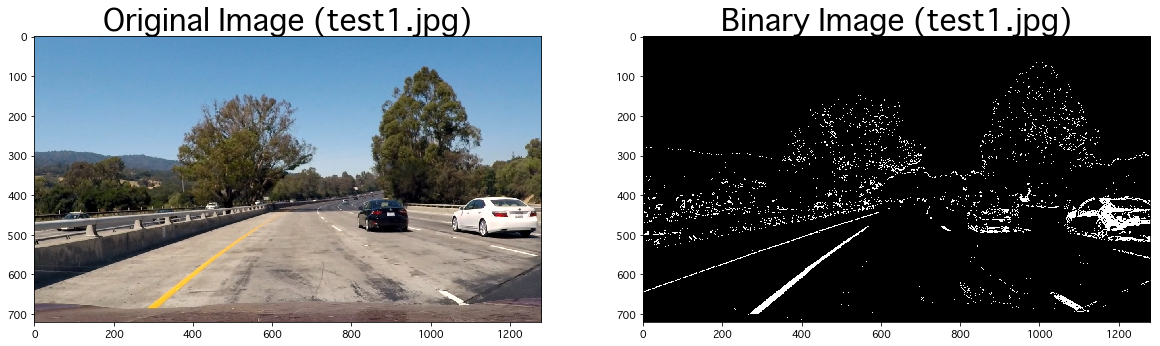

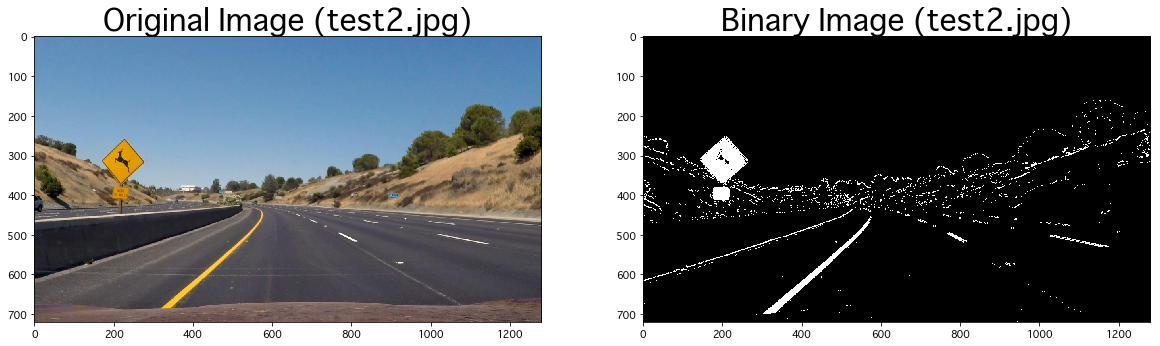

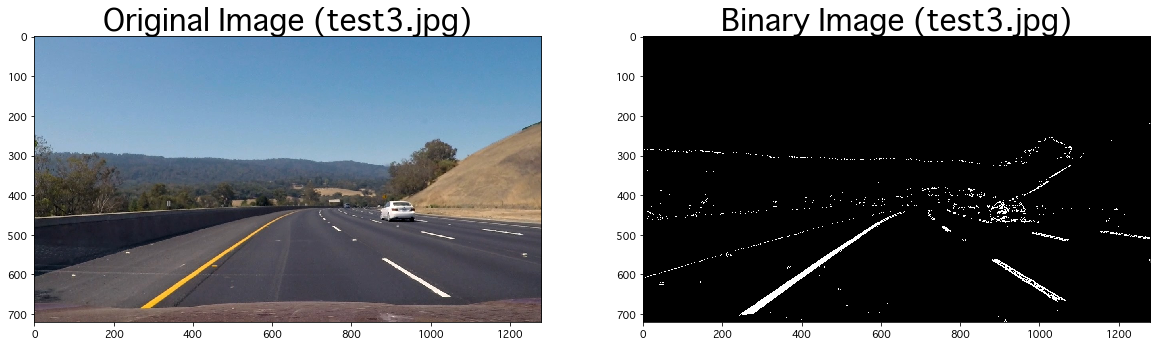

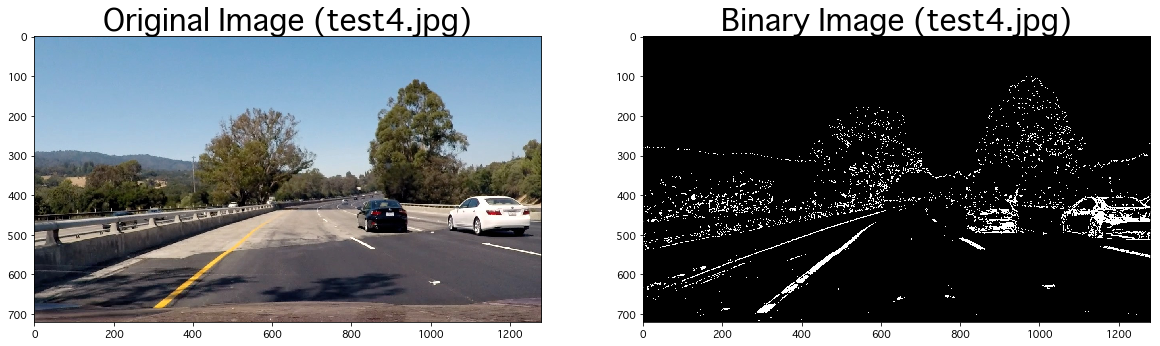

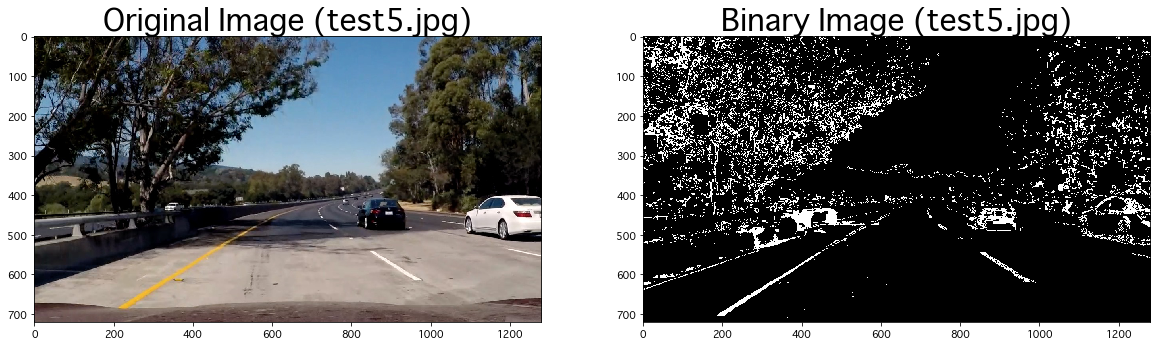

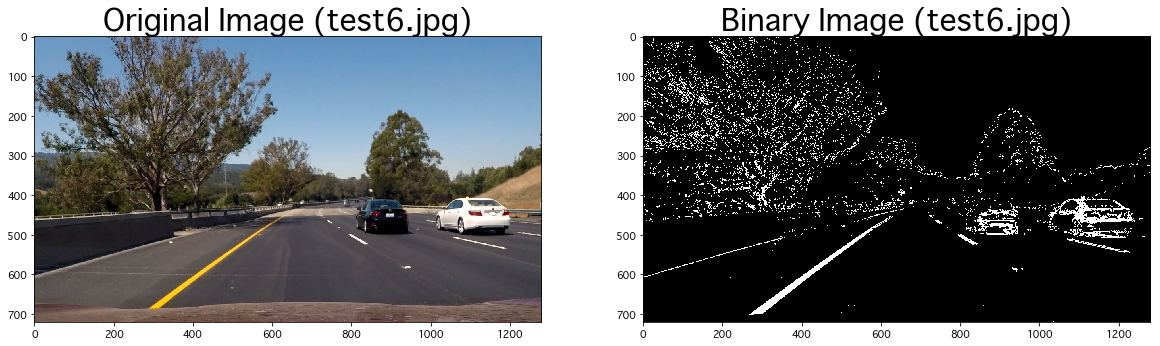

In [6]:
# Step through the list
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # undistort the image
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(undistort, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    #mag_binary = mag_thresh(undistort, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(undistort, sobel_kernel=ksize, thresh=(0.7, 1.3)) #, thresh=(0, np.pi/2))
    c_binary = hls_select(undistort, thresh=(180, 255))

    # Pre-process image template
    preprocessImage = np.zeros_like(c_binary)
    #preprocessImage[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (c_binary == 1)] = 1
    preprocessImage[((gradx == 1) & (grady == 1)) | (c_binary == 1)] = 1

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image (' + fname.split('/')[-1] + ')', fontsize=30)
    ax2.imshow(preprocessImage, cmap='gray')
    ax2.set_title('Binary Image (' + fname.split('/')[-1] + ')', fontsize=30)
    plt.savefig(fname.split('/')[0] + '/binary_test' + str(idx+1) + '.jpg', bbox_inches='tight')